In [116]:
# Imports
import pandas as pd
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import re
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import warnings
warnings.filterwarnings("ignore")

In [117]:
plt.rcParams['figure.dpi'] = 125
plt.ioff()

In [118]:
# Read data
def read_data():
    data = pd.read_csv('./data/Twitter_Data.csv')
    data = data.dropna()
    positive_data = data[data['category'] == 1]
    negative_data = data[data['category'] == -1]
    neutral_data = data[data['category'] == 0]
    min_length = min(len(positive_data), len(negative_data), len(neutral_data))
    positive = positive_data.sample(n = min_length, random_state = 1)
    negative = negative_data.sample(n = min_length, random_state = 1)
    neutral = neutral_data.sample(n = min_length, random_state = 1)
    balanced_data = pd.concat([positive, negative, neutral])
    balanced_data = balanced_data.sample(frac = 1, random_state = 1).reset_index(drop = True)
    return balanced_data

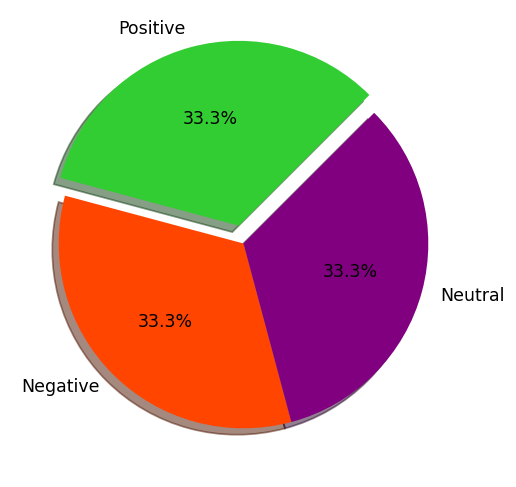

In [119]:
# Pie Plot
def plot_data():
    data = read_data()
    positive = data[data['category'] == 1]['category']
    negative = data[data['category'] == -1]['category']
    neutral = data[data['category'] == 0]['category']

    counter = [positive.count(), negative.count(), neutral.count()]
    plt.pie(counter,
       labels=["Positive","Negative","Neutral"],
       autopct='%1.1f%%',
       shadow=True,
       colors=['limegreen', 'orangered', 'purple'],
       startangle=45,
       explode=(0.1, 0, 0))
    return plt

plot_data().show()

In [120]:
# Preprocess data to get rid html tags and push emojis to text end
def preprocessor(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text() # Remove HTML tags
    text = re.sub(r'(?::|;|=)(?:-)?(?:\)|\(|D|P)', '', text) # Remove text-based emojis
    text = ' '.join(text.split()) # Remove unnecessary whitespaces
    emoji_pattern = re.compile(
        "["
        "\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "\U0001F300-\U0001F5FF"  # symbols & pictographs
        "\U0001F600-\U0001F64F"  # emoticons
        "\U0001F680-\U0001F6FF"  # transport & map symbols
        "\U0001F700-\U0001F77F"  # alchemical symbols
        "\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        "\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        "\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        "\U0001FA00-\U0001FA6F"  # Chess Symbols
        "\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        "\U00002702-\U000027B0"  # Dingbats
        "\U000024C2-\U0001F251"
        "]+"
    )
    text = emoji_pattern.sub(r'', text)
    return text
data = read_data()
data

,text,category
0,truth has finally come out unaccountable hoard...,-1.0
1,make every vote count you want vote against mo...,0.0
2,suddenly realized was singing modified version...,0.0
3,pmoanalysing modis rudrapur rally speech with ...,0.0
4,ridicules rahul for questioning modi,0.0
...,...,...
106522,hon’ble shri advani shri joshi both ask the mo...,-1.0
106523,noooooo modi save democracy,0.0
106524,sarada chit fund scam kolkata already been inv...,1.0
106525,will reason out why wasnt paid iran even thoug...,0.0


In [121]:
# Stemming and feature extraction
data = read_data()
data['text'] = data['text'].apply(str).apply(preprocessor)

porter = PorterStemmer()

def apply_porter(text):
    return [porter.stem(word) for word in text.split()]


tfidf = TfidfVectorizer(strip_accents = None, 
                        lowercase = False, 
                        preprocessor = None,
                        tokenizer = apply_porter, 
                        use_idf = True, 
                        norm = 'l2', 
                        smooth_idf = True)

In [122]:
# Extract data from dataframe
X_data = tfidf.fit_transform(data.text)
Y_data = data.category.values

In [123]:
# Train test split
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, random_state = 1, test_size = 0.2)

<center><h1>Logistic Regression</h1></center>

In [124]:
# Train Logistic Regression
classifier = LogisticRegressionCV(cv = 6, scoring = 'accuracy', random_state = 1, max_iter = 500, verbose = 3, n_jobs = 4)
classifier.fit(X_train, Y_train)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   6 | elapsed:   10.7s remaining:   21.6s
[Parallel(n_jobs=4)]: Done   6 out of   6 | elapsed:   20.3s finished


LogisticRegressionCV(cv=6, max_iter=500, n_jobs=4, random_state=1,
                     scoring='accuracy', verbose=3)

In [125]:
# Accuracy Check
accuracy = accuracy_score(Y_test, classifier.predict(X_test))
print("Logistic Regression Accuracy: {:.2f}%".format(accuracy * 100))

Logistic Regression Accuracy: 86.83%


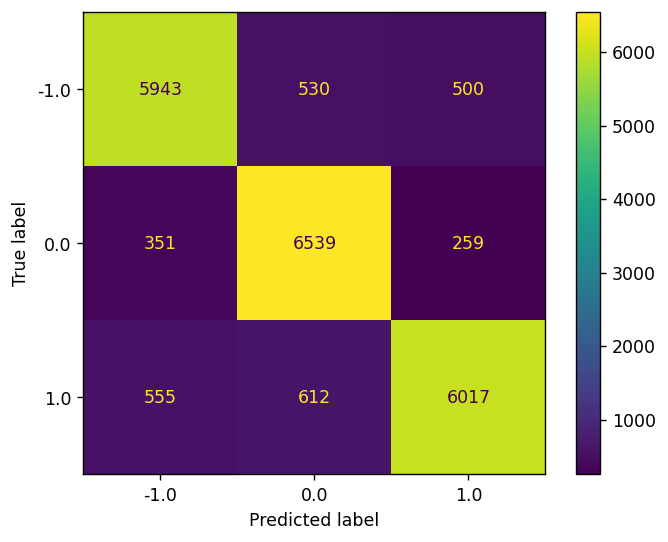

In [126]:
# Confusion Matrix
ConfusionMatrix = confusion_matrix(Y_test, classifier.predict(X_test))
matrix = ConfusionMatrixDisplay(ConfusionMatrix, display_labels = classifier.classes_)
matrix.plot()
plt.show()

<center><h1>SVM</h1></center>

In [127]:
# Define SVM Model
svm_classifier = SVC(kernel='linear', random_state = 1)

In [128]:
# Train SVM Model
svm_classifier.fit(X_train[:10000], Y_train[:10000])

SVC(kernel='linear', random_state=1)

In [129]:
Y_pred = svm_classifier.predict(X_test)

In [130]:
accuracy = accuracy_score(Y_test, Y_pred)
print("SVM Accuracy: {:.2f}%".format(accuracy * 100))

SVM Accuracy: 77.65%


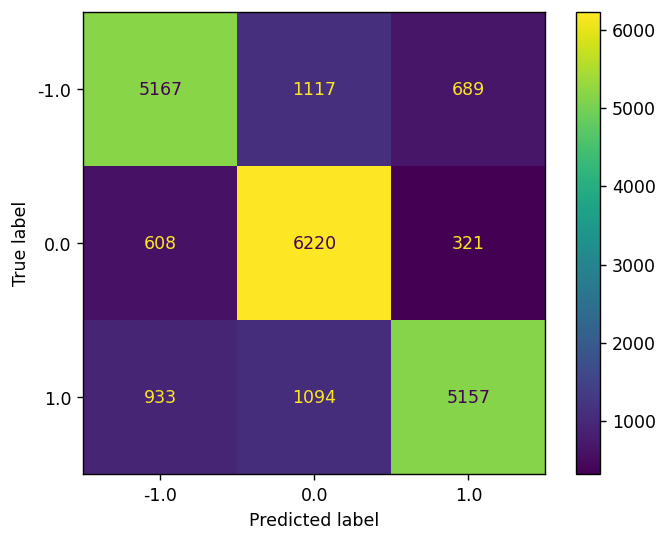

In [131]:
# Plot Confusion Matrix
ConfusionMatrix = confusion_matrix(Y_test, Y_pred)
ConfusionMatrixDisplay(confusion_matrix = ConfusionMatrix, display_labels = classifier.classes_).plot()
plt.show()


<center><h1>KNN</h1></center>

In [132]:
# Define KNN Model
knn_classifier = KNeighborsClassifier(n_neighbors = 100, metric = 'cosine', weights = 'distance')
knn_classifier.fit(X_train, Y_train)
y_pred = knn_classifier.predict(X_test)
accuracy = accuracy_score(Y_test, y_pred)
print(f"KNN Accuracy: {accuracy * 100:.2f}%")

KNN Accuracy: 55.24%


In [133]:
# param_grid = dict(weights=('uniform', 'distance'), metric=('minkowski', 'cosine', 'euclidean'))
# grid = GridSearchCV(knn_classifier, param_grid, cv = 10, scoring='accuracy', return_train_score=True)
# grid.fit(X_train[:5000], Y_train[:5000])
# y_pred = grid.predict(X_test)
# print(grid.best_score_)
# print(grid.best_params_)
# print(grid.best_estimator_)
# accuracy = accuracy_score(Y_test, y_pred)
# print("KNN Accuracy: {:.2f}%".format(accuracy * 100))
# pd.DataFrame(grid.cv_results_)[['mean_test_score', 'std_test_score', 'params']]
# print(grid.best_score_)
# print(grid.best_params_)
# print(grid.best_estimator_)

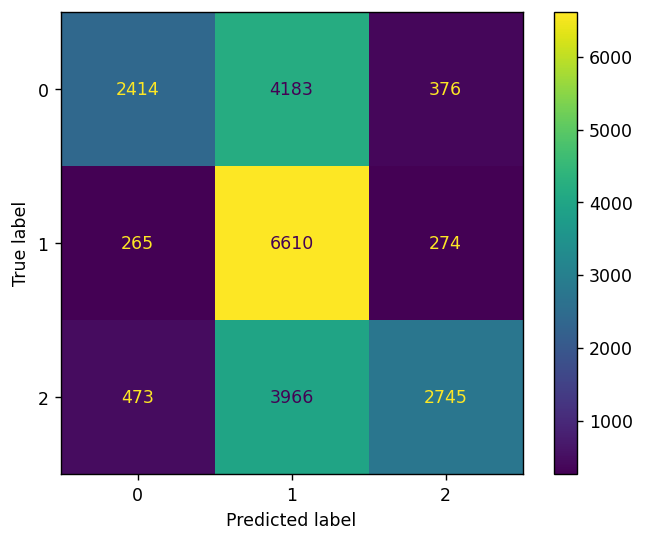

In [134]:
# Plot Confusion Matrix
ConfusionMatrix = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix = ConfusionMatrix).plot()
plt.show()

<center><h1>Naive Bayes</h1></center>

In [135]:
# Define Naive Bayes Model
naive_bayes_classifier = MultinomialNB()

In [136]:
# Train Naive Mayes Model
naive_bayes_classifier.fit(X_train, Y_train)

MultinomialNB()

In [137]:
y_pred = naive_bayes_classifier.predict(X_test)

In [138]:
# Compute accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Naive Bayes Accuracy: {:.2f}%".format(accuracy * 100))

Naive Bayes Accuracy: 68.59%


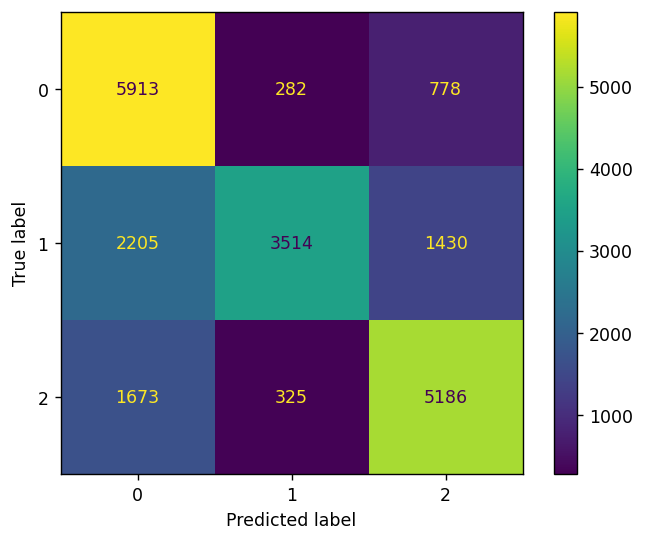

In [139]:
# Plot Confusion Matrix
ConfusionMatrix = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix = ConfusionMatrix).plot()
plt.show()


<center><h1>Decision Tree</h1></center>

In [140]:
# Define Decision Tree Model
decision_tree_classifier = DecisionTreeClassifier()

In [141]:
# Train Decision Tree Model
decision_tree_classifier.fit(X_train, Y_train)

DecisionTreeClassifier()

In [142]:
y_pred = decision_tree_classifier.predict(X_test)

In [143]:
# Compute Accuracy
accuracy = accuracy_score(Y_test, y_pred)
print("Decision Tree Accuracy: {:.2f}%".format(accuracy * 100))

Decision Tree Accuracy: 78.02%


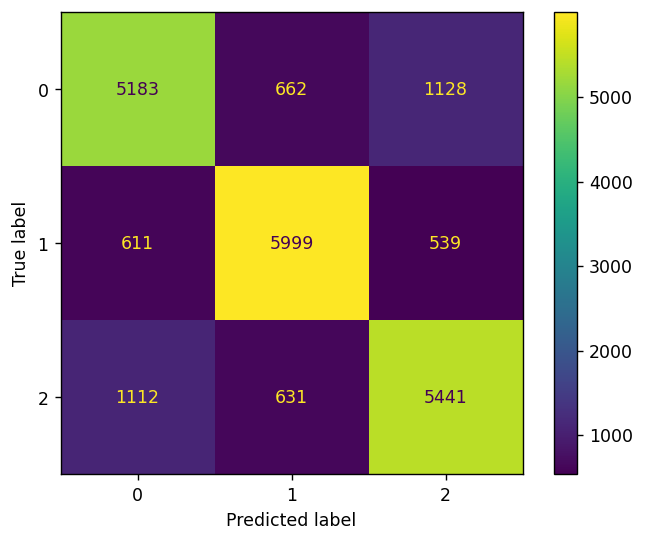

In [144]:
# Plot Confusion Matrix
ConfusionMatrix = confusion_matrix(Y_test, y_pred)
ConfusionMatrixDisplay(confusion_matrix = ConfusionMatrix).plot()
plt.show()